# Semantic Image Compression

## Encoder Decoder Network

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import numpy as np
from tqdm import tqdm
import time

In [33]:
class autoencoder(nn.Module):
    def __init__(self, channels, outputs, learning_rate, tb_dir, model_dir, weights=None):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 64, 4, 1)
        
        self.conv7 = nn.ConvTranspose2d(64, 512, 4, 1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.bn8 = nn.BatchNorm2d(256)
        self.conv9 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.conv10 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn10 = nn.BatchNorm2d(64)
        self.conv11 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.bn11 = nn.BatchNorm2d(32)
        self.conv12 = nn.ConvTranspose2d(32, outputs, 4, 2, 1)
        
        if weights is not None:
            self.loss = nn.CrossEntropyLoss(weights)
        else:
            self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.optimiser = optim.Adam(self.parameters(), self.learning_rate)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.tensorboard = SummaryWriter(tb_dir + f'/ae-{int(time.time())}')
        self.to(self.device)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv6(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv9(x)
        x = self.bn9(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv10(x)
        x = self.bn10(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv11(x)
        x = self.bn11(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv12(x)
        x = T.sigmoid(x)
        
        return x
    
    def compress(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv6(x)
        
        return x
    
    def save_model(self, r, t, ep):
        T.save(self.state_dict(), model_dir + f"/ae-{int(time.time())}")

In [36]:
ae = autoencoder(1, 13, 0.001, 'ae-models/dummy', 'ae-runs/dummy', T.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
ae.load_state_dict(T.load('ae-models/Clear Noon Dry/ae-1649055310'))

<All keys matched successfully>

In [6]:
e = autoencoder(1, 13, 0.001)
summary(e, (1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          544
├─Conv2d: 1-2                            [-1, 64, 32, 32]          32,832
├─BatchNorm2d: 1-3                       [-1, 64, 32, 32]          128
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,200
├─BatchNorm2d: 1-5                       [-1, 128, 16, 16]         256
├─Conv2d: 1-6                            [-1, 256, 8, 8]           524,544
├─BatchNorm2d: 1-7                       [-1, 256, 8, 8]           512
├─Conv2d: 1-8                            [-1, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-9                       [-1, 512, 4, 4]           1,024
├─Conv2d: 1-10                           [-1, 64, 1, 1]            524,352
├─ConvTranspose2d: 1-11                  [-1, 512, 4, 4]           524,800
├─BatchNorm2d: 1-12                      [-1, 512, 4, 4]           1,024
├─ConvTranspose2d: 1-13                  [-1

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          544
├─Conv2d: 1-2                            [-1, 64, 32, 32]          32,832
├─BatchNorm2d: 1-3                       [-1, 64, 32, 32]          128
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,200
├─BatchNorm2d: 1-5                       [-1, 128, 16, 16]         256
├─Conv2d: 1-6                            [-1, 256, 8, 8]           524,544
├─BatchNorm2d: 1-7                       [-1, 256, 8, 8]           512
├─Conv2d: 1-8                            [-1, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-9                       [-1, 512, 4, 4]           1,024
├─Conv2d: 1-10                           [-1, 64, 1, 1]            524,352
├─ConvTranspose2d: 1-11                  [-1, 512, 4, 4]           524,800
├─BatchNorm2d: 1-12                      [-1, 512, 4, 4]           1,024
├─ConvTranspose2d: 1-13                  [-1

In [8]:
mask = np.load('images/Clear Noon Dry/Semantic/sem_image100.npy')

In [9]:
maskT = T.tensor(mask)

In [14]:
maskT = T.reshape(maskT, (1, 1, 128, 128))

In [15]:
maskT.shape

torch.Size([1, 1, 128, 128])

In [20]:
maskT = maskT.to('cuda')

In [21]:
fpass = e.forward(maskT.float())

In [23]:
fpass.shape

torch.Size([1, 13, 128, 128])

In [27]:
fpass

tensor([[[[0.4934, 0.4651, 0.5269,  ..., 0.4851, 0.5091, 0.4853],
          [0.4724, 0.4894, 0.4879,  ..., 0.5167, 0.4876, 0.4821],
          [0.4673, 0.4497, 0.4960,  ..., 0.4146, 0.5010, 0.4550],
          ...,
          [0.4735, 0.5103, 0.4830,  ..., 0.4946, 0.4407, 0.5006],
          [0.4818, 0.4830, 0.5148,  ..., 0.4457, 0.5451, 0.4970],
          [0.4866, 0.5129, 0.5378,  ..., 0.4726, 0.5250, 0.4905]],

         [[0.5068, 0.4830, 0.5441,  ..., 0.4765, 0.5221, 0.4992],
          [0.5158, 0.4972, 0.5019,  ..., 0.5520, 0.4329, 0.4740],
          [0.4998, 0.4733, 0.4999,  ..., 0.4690, 0.5062, 0.5198],
          ...,
          [0.4985, 0.5134, 0.4948,  ..., 0.5034, 0.5208, 0.4860],
          [0.5034, 0.4993, 0.5400,  ..., 0.4869, 0.5122, 0.5159],
          [0.5220, 0.5260, 0.5071,  ..., 0.5074, 0.5331, 0.4974]],

         [[0.4806, 0.5050, 0.4771,  ..., 0.5010, 0.4729, 0.5004],
          [0.5053, 0.4530, 0.5005,  ..., 0.4381, 0.4904, 0.4794],
          [0.4955, 0.4949, 0.4511,  ..., 0

In [32]:
pred = T.argmax(fpass, dim=1)
pred.shape

torch.Size([1, 128, 128])

In [33]:
target = T.reshape(maskT, (1, 128, 128))
target.shape

torch.Size([1, 128, 128])

In [37]:
pred

tensor([[[ 6,  7,  3,  ...,  7,  3,  6],
         [ 3,  4, 11,  ...,  1, 12,  7],
         [ 6, 11,  3,  ...,  7,  9,  2],
         ...,
         [ 3,  1,  3,  ...,  9, 12,  2],
         [ 6, 11,  3,  ..., 11,  0, 12],
         [11,  7,  0,  ...,  7,  1,  7]]], device='cuda:0')

In [36]:
target

tensor([[[3, 3, 3,  ..., 3, 3, 3],
         [1, 3, 3,  ..., 3, 1, 1],
         [1, 1, 3,  ..., 1, 1, 1],
         ...,
         [7, 7, 7,  ..., 7, 7, 7],
         [7, 7, 7,  ..., 7, 7, 7],
         [7, 7, 7,  ..., 7, 7, 7]]], device='cuda:0', dtype=torch.uint8)

In [38]:
input1 = T.randn(3, 5, requires_grad=True)
target1 = T.empty(3, dtype=T.long).random_(5)
output = e.loss(input1, target1)

In [39]:
output

tensor(1.7663, grad_fn=<NllLossBackward>)

In [40]:
input1.shape

torch.Size([3, 5])

In [43]:
input1

tensor([[-1.9216,  0.2944,  0.3745, -0.6319,  1.1757],
        [-1.2880,  0.1013,  2.2923, -1.6622,  0.4937],
        [-0.3749, -1.2438,  0.0444, -1.3109,  1.7511]], requires_grad=True)

In [41]:
target1.shape

torch.Size([3])

In [44]:
target1

tensor([4, 3, 4])

In [45]:
l = e.loss(fpass.float(), target.long())
l

tensor(2.5510, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [24]:
comp = e.compress(maskT.float())

In [26]:
comp.shape

torch.Size([1, 64, 1, 1])

## Training Image Class Weights

In [13]:
from random import sample
from os import listdir

In [67]:
sems = [name for name in listdir('images/Clear Noon Dry/Semantic/')]
sample_sems = sample(sems, 20000)

In [68]:
tag_count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

In [70]:
for i in range(len(sample_sems)):
    im = np.load('images/Clear Noon Dry/Semantic/' + sample_sems[i])
    unique, counts = np.unique(im, return_counts=True)
    temp = dict(zip(unique, counts))
    for tag in temp:
        tag_count[tag] += temp[tag]

In [71]:
tag_count

{0: 4012,
 1: 28238868,
 2: 300802,
 3: 66028772,
 4: 0,
 5: 5122881,
 6: 6709721,
 7: 197078613,
 8: 5642633,
 9: 6383513,
 10: 47894,
 11: 12115097,
 12: 7194}

In [72]:
sum1 = 0
weights = []

for key in tag_count:
    sum1 += tag_count[key]

for key in tag_count:
    weights.append(tag_count[key]/sum1)
    
weights

[1.224365234375e-05,
 0.08617818603515626,
 0.000917974853515625,
 0.20150382080078125,
 0.0,
 0.015633792114257812,
 0.02047644348144531,
 0.6014361968994141,
 0.01721994934082031,
 0.019480935668945314,
 0.000146160888671875,
 0.036972341918945315,
 2.1954345703125e-05]

In [75]:
inv_weights = []
for weight in weights:
    inv_weights.append(1 - weight)


inv_weights

[0.9999877563476562,
 0.9138218139648437,
 0.9990820251464844,
 0.7984961791992188,
 1.0,
 0.9843662078857421,
 0.9795235565185547,
 0.3985638031005859,
 0.9827800506591797,
 0.9805190643310547,
 0.9998538391113281,
 0.9630276580810547,
 0.9999780456542968]

In [92]:
final_weights = inv_weights/sum(inv_weights)

In [93]:
sum(final_weights)

1.0000000000000002

In [94]:
final_weights = T.tensor(final_weights)

In [95]:
final_weights

tensor([0.0833, 0.0762, 0.0833, 0.0665, 0.0833, 0.0820, 0.0816, 0.0332, 0.0819,
        0.0817, 0.0833, 0.0803, 0.0833], dtype=torch.float64)

In [98]:
sum1/(128*128)

20000.0

## Training Encoder Decoder Network

In [133]:
class SegmentationDataset(Dataset):
    def __init__(self, mask_paths, num_classes, device, path):
        self.mask_paths = mask_paths
        self.num_classes = num_classes
        self.device = device
        self.path = path

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        mask = np.load(self.path + self.mask_paths[idx])
        im = T.from_numpy(mask).float().to(self.device)
        im = T.reshape(im, (1, 128, 128))
        mask = T.from_numpy(mask).long().to(self.device)
        mask = T.reshape(mask, (128, 128))
        return im, mask

In [111]:
sems = [name for name in listdir('images/Clear Noon Dry/Semantic/')]
len(sems)

84998

In [134]:
dataset = SegmentationDataset(sems[:84992], 13, 'cuda', 'images/Clear Noon Dry/Semantic/')

In [135]:
data = DataLoader(dataset, batch_size=32)

In [136]:
epochs = 30
aed = autoencoder(1, 13, 0.001, final_weights.float())
device = 'cuda'
it = 1
losses = []

for epoch in tqdm(range(1, epochs + 1), ascii=True, unit='epochs'):
    for i, (x, y) in enumerate(data):
        aed.optimiser.zero_grad()
        
        preds = aed.forward(x).to(device)
        
        loss = aed.loss(preds, y).to(device)
        loss.backward()
        aed.optimiser.step()
        aed.tensorboard.add_scalar('Loss', loss.item(), it)
        it += 1
        losses.append(loss)
        
        

100%|##########| 30/30 [5:35:46<00:00, 671.55s/epochs]  


In [138]:
aed.save_model(1, 1, 1)

# Training RGB to Semantic Encoder Network

In [ ]:
def load_data(path):
    """
    Helper method to load the dataset
    :param path: Path to location of dataset
    :return: lists of all the images and masks
    """
    dirs = ['Clear Noon Dry', 'Cloudy Evening HR', 'Cloudy Evening LR', 'Night Dry', 'Night HR', 'Night LR']
    all_images = []
    all_masks = []

    for d in dirs:
        images_list = list(path.glob(f'{d}/RGB/*.npy'))
        images_list.sort()
        masks_list = list(path.glob(f'{d}/Semantic/*.npy'))
        masks_list.sort()
        if len(images_list) != len(masks_list):
            raise ValueError('Invalid data loaded')
        pairs = zip(images_list, masks_list)
        pairs = sample(list(pairs), 20000)
        images_list, masks_list = zip(*pairs)
        all_images += images_list
        all_masks += masks_list
    
    all_images = np.array(all_images)
    all_masks = np.array(all_masks)
    
    return all_images, all_masks

## Testing 

In [14]:
test_sems = [name for name in listdir('images/Cloudy Evening HR/Semantic/')]
# test_sems =

In [8]:
ae = autoencoder(1, 13, 0.001, T.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]).float())
ae.load_state_dict(T.load('ae-models/Clear Noon Dry/ae-1649055310'))

<All keys matched successfully>

In [27]:
c = ae.compress(mt.float())
lat = T.reshape(c, (1, 64))
lat = lat.cpu().detach().numpy()
np.reshape(lat, (64)).shape

(64,)

In [32]:
np.concatenate((np.array([1, 1, 1]), np.array([])), axis=None)

array([1., 1., 1.])

In [16]:
m = np.load('images/Cloudy Evening HR/Semantic/' + test_sems[0])
mt = T.tensor(m).to('cuda')
mt = T.reshape(mt, (1, 1, 128, 128))
# p = aed.forward(mt.float())

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt

In [147]:
def mask_to_image(array):
    image = np.zeros((128, 128, 3))
    for i in range(128):
        for j in range(128):
            image[i, j] = pixels[array[i, j]]
    
    return image.astype('uint8')

In [148]:
pixels = {0.0:np.array([int(0), int(0), int(0)]),
          1.0:np.array([int(70), int(70), int(70)]),
          2.0:np.array([int(100), int(40), int(40)]),
          3.0:np.array([int(55), int(90), int(80)]),
          4.0:np.array([int(220), int(20), int(60)]),
          5.0:np.array([int(153), int(153), int(153)]),
          6.0:np.array([int(157), int(234), int(50)]),
          7.0:np.array([int(128), int(64), int(128)]),
          8.0:np.array([int(244), int(35), int(232)]),
          9.0:np.array([int(107), int(142), int(35)]),
          10.0:np.array([int(0), int(0), int(142)]),
          11.0:np.array([int(102), int(102), int(156)]),
          12.0:np.array([int(220), int(220), int(0)])}

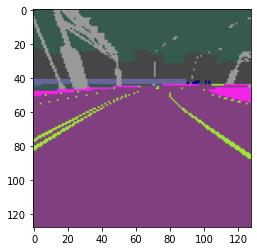

In [149]:
img = mask_to_image(m)
plt.imshow(img)
plt.show()

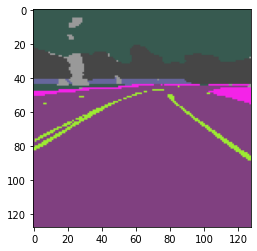

In [158]:
ma = T.argmax(p, dim=1)
ma = ma.cpu().detach().numpy()
ma = np.reshape(ma, (128, 128))
img = mask_to_image(ma)
plt.imshow(img)
plt.show()

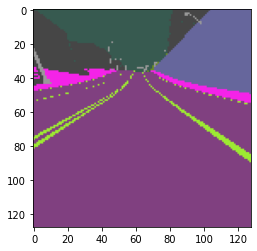

In [159]:
m1 = np.load('images/Clear Noon Dry/Semantic/' + sems[0])
mt1 = T.tensor(m1).to('cuda')
mt1 = T.reshape(mt1, (1, 1, 128, 128))
img = mask_to_image(m1)
plt.imshow(img)
plt.show()

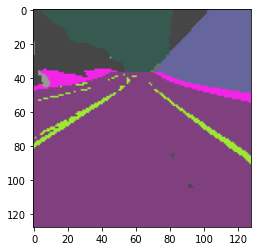

In [161]:
p1 = aed.forward(mt1.float())
ma1 = T.argmax(p1, dim=1)
ma1 = ma1.cpu().detach().numpy()
ma1 = np.reshape(ma1, (128, 128))
img = mask_to_image(ma1)
plt.imshow(img)
plt.show()

In [162]:
sems[9]

'sem_image64198.npy'

## Old Stuff

In [17]:
class decoder(nn.Module):
    def __init__(self, outputs, learning_rate):
        super(decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 512, 4, 1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, outputs, 4, 2, 1)
        
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.optimiser = optim.Adam(self.parameters(), self.learning_rate)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.conv6(x)
        x = T.sigmoid(x)
        
        return x

In [ ]:
class EDNetwork:
    def __init__(self):
        self.downConv = encoder(1, 0.001)
        self.upConv = decoder(13, 0.001)
        

In [19]:
e = encoder(1, 0.001)
summary(e, (1, 128, 128))
d = decoder(13, 0.001)
summary(d, (64, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          544
├─Conv2d: 1-2                            [-1, 64, 32, 32]          32,832
├─BatchNorm2d: 1-3                       [-1, 64, 32, 32]          128
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,200
├─BatchNorm2d: 1-5                       [-1, 128, 16, 16]         256
├─Conv2d: 1-6                            [-1, 256, 8, 8]           524,544
├─BatchNorm2d: 1-7                       [-1, 256, 8, 8]           512
├─Conv2d: 1-8                            [-1, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-9                       [-1, 512, 4, 4]           1,024
├─Conv2d: 1-10                           [-1, 64, 1, 1]            524,352
Total params: 3,313,056
Trainable params: 3,313,056
Non-trainable params: 0
Total mult-adds (M): 136.84
Input size (MB): 0.06
Forward/backward pass size (MB): 2.88
Params size (MB): 12.64
Esti

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 512, 4, 4]           524,800
├─BatchNorm2d: 1-2                       [-1, 512, 4, 4]           1,024
├─ConvTranspose2d: 1-3                   [-1, 256, 8, 8]           2,097,408
├─BatchNorm2d: 1-4                       [-1, 256, 8, 8]           512
├─ConvTranspose2d: 1-5                   [-1, 128, 16, 16]         524,416
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ConvTranspose2d: 1-7                   [-1, 64, 32, 32]          131,136
├─BatchNorm2d: 1-8                       [-1, 64, 32, 32]          128
├─ConvTranspose2d: 1-9                   [-1, 32, 64, 64]          32,800
├─BatchNorm2d: 1-10                      [-1, 32, 64, 64]          64
├─ConvTranspose2d: 1-11                  [-1, 13, 128, 128]        6,669
Total params: 3,319,213
Trainable params: 3,319,213
Non-trainable params: 0
Total mult-adds (M): 654.31
Input size (MB):